# Setup

In [23]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from google.colab import drive
import os

import sklearn.metrics
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from sklearn.metrics import classification_report

In [24]:
drive.mount("/content/drive", force_remount=True)
root = "/content/drive/My Drive/Horse Category Classification"
os.chdir(root)
data_root = root + "/data"
data_root_train = data_root + "/train"
data_root_test = data_root + "/test"

Mounted at /content/drive


In [25]:
BATCH_SIZE = 32
HEIGHT = 224
WIDTH = 224

# 02 Overfit

In this notebook I am loading the train data and training it for many epochs. want to see whether I can overfit it to perfect (1.0) F1 Scores. That would mean that the model can perform the basic task that I am after. As a model I am using a basic resnet50 retrained for my purposes.

In [26]:
class_names=['heavy', 'light', 'pony']

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_root_train,
    labels='inferred',
    label_mode='categorical',
    class_names=class_names,
    color_mode='rgb',
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    validation_split=0.2,
    seed=42,
    subset="training"
)

Found 477 files belonging to 3 classes.
Using 382 files for training.


In [27]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [28]:
def recompile_custom_output(base_model):
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    # add a fully-connected layer
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(3, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)

    # first: train only the top layers (which were randomly initialized)
    # i.e. freeze all convolutional ResNet50 layers
    for layer in base_model.layers:
        layer.trainable = False

    # compile the model (should be done *after'* setting layers to non-trainable)
    model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [29]:
resnet50 = ResNet50(weights='imagenet', include_top=False)
model = recompile_custom_output(resnet50)

In [30]:
epochs=15
history = model.fit(
  train_ds,
  epochs=epochs
)

Epoch 1/15
12/12 [==============================] - 91s 7s/step - loss: 5.5567 - accuracy: 0.5340
Epoch 2/15
12/12 [==============================] - 76s 6s/step - loss: 1.1820 - accuracy: 0.6754
Epoch 3/15
12/12 [==============================] - 78s 7s/step - loss: 0.5839 - accuracy: 0.8115
Epoch 4/15
12/12 [==============================] - 76s 6s/step - loss: 0.5863 - accuracy: 0.7853
Epoch 5/15
12/12 [==============================] - 77s 6s/step - loss: 0.3616 - accuracy: 0.8717
Epoch 6/15
12/12 [==============================] - 76s 6s/step - loss: 0.5215 - accuracy: 0.8220
Epoch 7/15
12/12 [==============================] - 79s 7s/step - loss: 0.2200 - accuracy: 0.9162
Epoch 8/15
12/12 [==============================] - 76s 6s/step - loss: 0.2167 - accuracy: 0.9162
Epoch 9/15
12/12 [==============================] - 75s 6s/step - loss: 0.1070 - accuracy: 0.9581
Epoch 10/15
12/12 [==============================] - 78s 6s/step - loss: 0.2948 - accuracy: 0.9215
Epoch 11/15
12/12 [

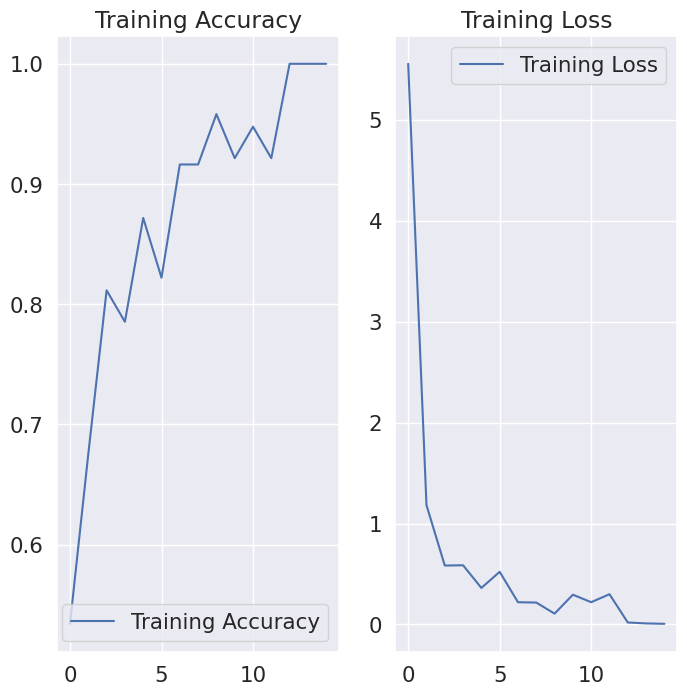

In [31]:
acc = history.history['accuracy']
loss = history.history['loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.legend(loc='lower right')
plt.title('Training Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.legend(loc='upper right')
plt.title('Training Loss')
plt.show()

In [32]:
def labels_categorical_batch_dataset(ds):
    import numpy as np

    test_ls = list(ds.as_numpy_iterator())
    true_labels = []
    for batch in test_ls:
        for batchitem in batch[1].tolist():
            true_labels.append(np.argmax(batchitem))
    return true_labels

def plot_cm(confusion_matrix, class_names):
    import pandas as pd
    import seaborn as sn
    import matplotlib.pyplot as plt

    df_cm = pd.DataFrame(confusion_matrix, columns=class_names, index = class_names)
    df_cm.index.name = 'Actual'
    df_cm.columns.name = 'Predicted'
    plt.figure(figsize = (10,7))
    sn.set(font_scale=1.4)
    sn.heatmap(df_cm, cmap="Reds", annot=True, annot_kws={"size": 12}, fmt='g')

In [33]:
trainset_predictions = model.predict(train_ds)
train_predicted_labels = [prediction.argmax() for prediction in trainset_predictions]
train_true_labels = labels_categorical_batch_dataset(train_ds)

12/12 [==============================] - 91s 7s/step


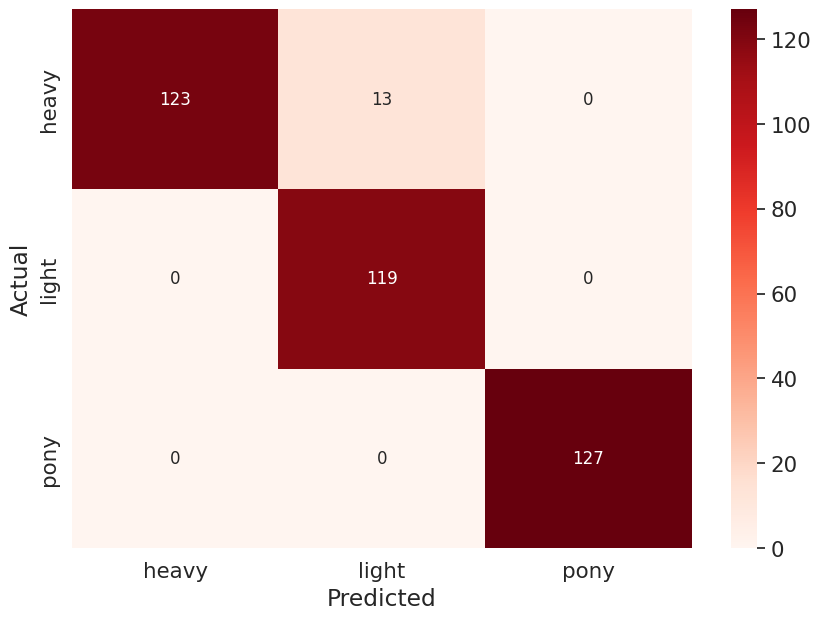

In [34]:
confusion_matrix_train = np.array(tf.math.confusion_matrix(train_true_labels, train_predicted_labels))
confusion_matrix_train = tf.math.confusion_matrix(train_true_labels, train_predicted_labels)
plot_cm(confusion_matrix_train, class_names)

In [35]:
print(classification_report(train_true_labels,train_predicted_labels))

              precision    recall  f1-score   support

           0       1.00      0.90      0.95       136
           1       0.90      1.00      0.95       119
           2       1.00      1.00      1.00       127

    accuracy                           0.97       382
   macro avg       0.97      0.97      0.97       382
weighted avg       0.97      0.97      0.97       382



# Summary

I trained the model for 15 epochs and it provides me with the close to perfect scores but not quite. To me that is not satisfactory yet.